In [1]:
def distribution_prices():
    pass

In [49]:
def special_day_analysis(ebd):
    import pandas as pd
    import sys, os
    sys.path.append(os.path.join(os.path.dirname(''), '../..'))
    from proj2_eniac_price_discounts.src.DSBC_proj2_utils import unpack_dict, pack_dict
    products, orders, orderlines, brands = unpack_dict(ebd)
    
    #
    all_orders = orderlines.merge(orders, right_on='order_id', left_on='id_order')
    all_orders =  all_orders.assign(
            created_day = pd.to_datetime(all_orders['created_date']).dt.strftime('%-j'),
            day = pd.to_datetime(all_orders['date']).dt.strftime('%j'),
            year = pd.to_datetime(all_orders['date']).dt.strftime('%Y')
    ).query('year != "2018"')
    
    all_orders = get_discounts(all_orders, products)
    disc_col = 'discount_perc'
    
    #counts the number of occurences of all states
    from collections import Counter
    def count_state_to_dict(x):
        state_dict = {
            'Cancelled': 0, 
            'Completed': 0, 
            'Pending': 0, 
            'Shopping Basket': 0, 
            'Place Order': 0
        }
    
        state_dict.update(Counter(x.tolist()))
        return pd.DataFrame(state_dict, index=[int(x.name) - 1])

    #multiple index resets necessary in order to put all columns together
    grpday = all_orders.groupby('day')
    all_orders_grpday_statecount = (
        grpday['state']
        .apply(count_state_to_dict)
        .reset_index()
        .drop('level_1', axis=1)
    )
    all_orders_grpday_statecount.loc[:,disc_col + '_sum'] = grpday[disc_col].sum().reset_index()[disc_col]
    all_orders_grpday_statecount.loc[:,disc_col + '_avg'] = grpday[disc_col].mean().reset_index()[disc_col]
    return all_orders_grpday_statecount

In [50]:
def corr_heatmap(df):
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot  as plt
    
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5) 

In [51]:
def get_discounts(all_orders, products):    
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    ol_prices = (
    all_orders                             #<------ changed
        .groupby(by=['sku',"day",'state']) #<------ changed
        .agg(
            min_ol_price=("unit_price", "min"),
            mean_ol_price=("unit_price", "mean"),
            max_ol_price=("unit_price", "max"))
        .reset_index()
    )
    ol_prices.head()
    ol_prices.mean_ol_price.isnull().sum()

    products01 = pd.merge(products, ol_prices, left_on="sku", right_on="sku", how='inner')
    
    products01["price_diff"] = products01["price"] - products01["mean_ol_price"]
    products01["discount_perc"] = 100-products01["mean_ol_price"]/products01["price"]*100
    
    return products01

In [57]:
def plot_discount_over_days(disc_kind):
    import seaborn as sns
    g = sns.relplot(
        data=all_orders_grpday_statecount, 
        kind='line',
        x='day', 
        y='discount_perc_' + disc_kind,
        linewidth = 2.5,
        aspect=2
    )
    return g

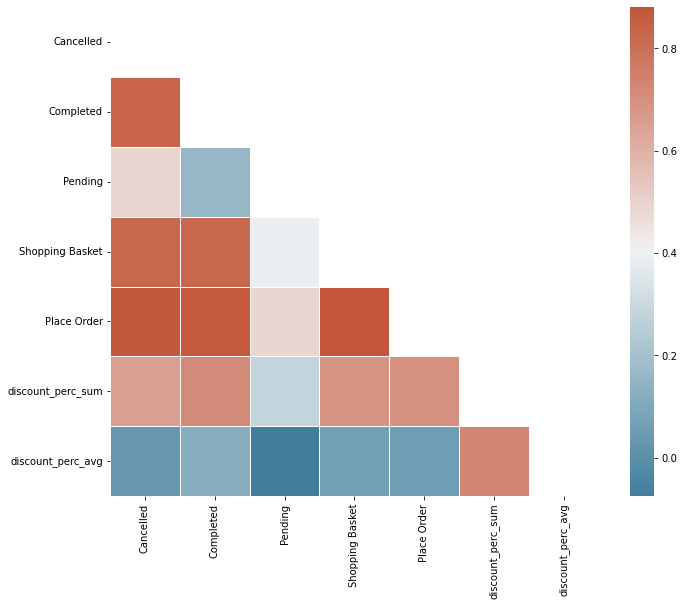

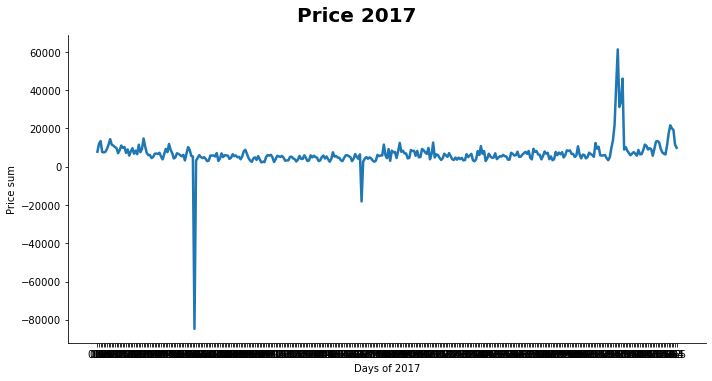

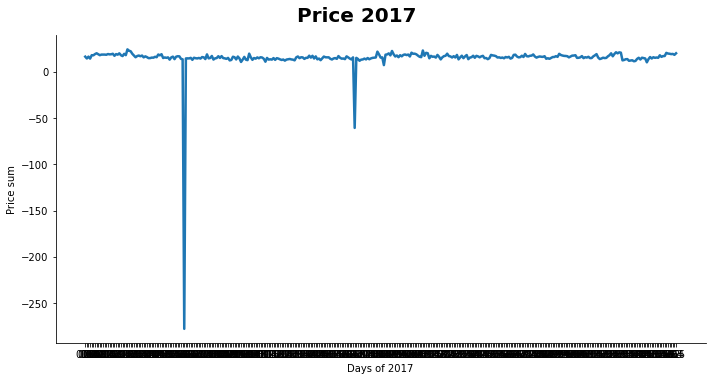

In [58]:
if True:
    import nbimporter
    import sys, os
    sys.path.append(os.path.join(os.path.dirname(''), '../..'))
    from proj2_eniac_price_discounts.DSBC_proj2_main import load_clean_data

    ebd = load_clean_data(path = '../data/')
    all_orders_grpday_statecount = special_day_analysis(ebd)
    
    #plots
    corr_heatmap(all_orders_grpday_statecount)
    
    g = plot_discount_over_days('sum')
    g.fig.suptitle('Price 2017', y=1.05, fontsize=20, fontweight='bold')
    g.set_axis_labels("Days of 2017", "Price sum") 
    
    g = plot_discount_over_days('avg')
    g.fig.suptitle('Price 2017', y=1.05, fontsize=20, fontweight='bold')
    g.set_axis_labels("Days of 2017", "Price sum") 

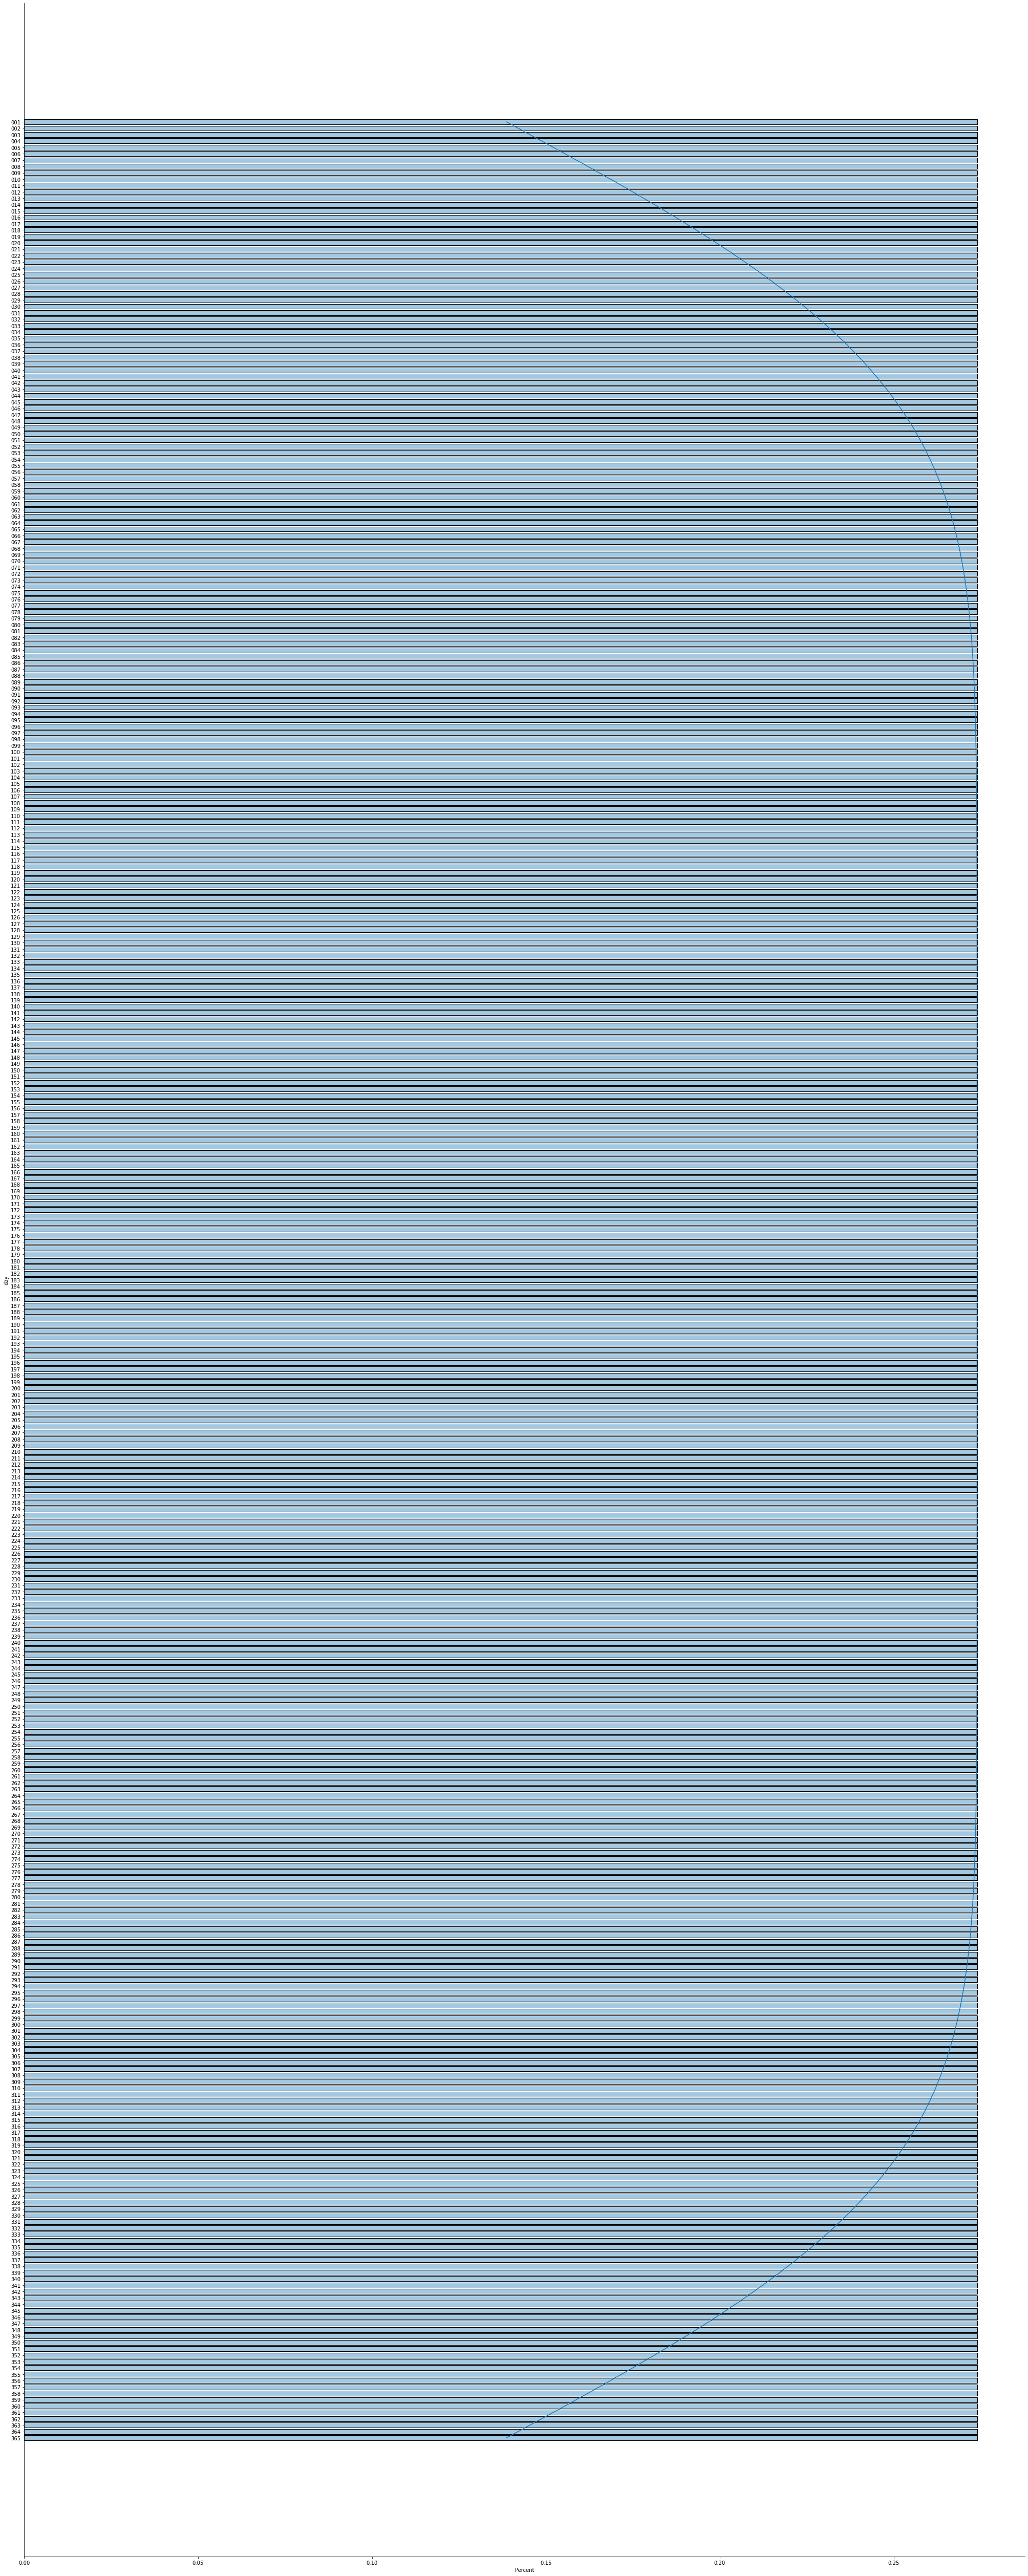

In [24]:
import seaborn as sns
g = sns.displot(
    data=all_orders_grpday_statecount,
    kind='hist',
    #x='completed',
    y='day', 
    alpha=.4, # add transparency to you chart
    #multiple="stack",
    element='bars',
    stat='percent',
    shrink=.8,
    kde=True, # add a density line in the histogram
    height=70,
    aspect=.4
)